# Compressão Lempel-Ziv-Welch (LZW)

<br>

* Método de compressão sem perdas
* Codificação baseada em dicionário
* Foca na redundância espacial

## Importação de Bibliotecas

In [1]:
from PIL import Image
import struct
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Funções Auxiliares

* **lzw_encode( ):** recebe uma sequência de bytes e retorna uma lista de códigos comprimidos usando o algoritmo LZW.
* **lzw_decode( ):** recebe uma lista de códigos comprimidos e retorna a sequência de bytes descomprimida.
* **calcEntropy(  ):** calcula a entropia de uma imagem. Essa função foi retirada de um notebook disponibilizado no Moodle.

In [2]:
# Codificação LZW
def lzw_encode(dados):
    tamanho_dicionario = 256 # tamanho inicial do dicionário
    dicionario = {bytes([i]): i for i in range(tamanho_dicionario)} # dicionário inicial mapeando cada byte para seu valor
    resultado = [] # lista onde os códigos comprimidos serão armazenados
    s = bytes() # sequência atual de bytes que está sendo processado
    
    for byte in dados: # para cada byte na entrada dados
        sc = s + bytes([byte]) # sequência atual concatenada com o próximo byte
        if sc in dicionario:
            s = sc
        else:
            resultado.append(dicionario[s])
            dicionario[sc] = tamanho_dicionario
            tamanho_dicionario += 1
            s = bytes([byte])
    
    if s:
        resultado.append(dicionario[s])
        
    return resultado

In [3]:
# Decodificação LZW
def lzw_decode(dados_codificados):
    tamanho_dicionario = 256
    dicionario = {i: bytes([i]) for i in range(tamanho_dicionario)}
    
    s = bytes([dados_codificados.pop(0)]) # retira o primeiro código comprimido e inicializa 's' com esse byte
    resultado = bytearray(s) # lista para armazenar os bytes descomprimidos
    
    for k in dados_codificados: # para cada código comprimido em dados_codificados
        if k in dicionario: # se o código está no dicionário
            entrada = dicionario[k] # recupera a entrada
        elif k == tamanho_dicionario: # se o código é igual a tamanho_dicionario
            entrada = s + s[:1] # usa a sequência anterior 's' concatenada com seu primeiro byte
        else:
            raise ValueError('k mal compactado: %s' % k)
        
        resultado.extend(entrada) # adiciona a entrada ao resultado
        
        # atualiza o dicionário
        dicionario[tamanho_dicionario] = s + entrada[:1]
        tamanho_dicionario += 1
        
        s = entrada # atualiza 's' para a entrada atual
        
    return bytes(resultado) # retorna o resultado convertido para bytes

In [4]:
# Entropia da imagem
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

## Funções de compressão e descompressão

* **compressao_imagem( ):** abre uma imagem, converte-a para uma sequência de bytes, comprime esses bytes usando o algoritmo de codificação LZW e salva os dados comprimidos em um arquivo.
* **decompressao_imagem( ):** lê os dados comprimidos de um arquivo, descomprime-os usando o algoritmo de decodificação LZW e reconstrói a imagem, salvando-a em um novo arquivo.

In [5]:
# Compressão da imagem
def compressao_imagem(input_image_path, output_compressed_path):
    # abrir a imagem e convertê-la para bytes em escala de cinza
    with Image.open(input_image_path) as img:
        img = img.convert('L')
        img_bytes = img.tobytes()
        tamanho_original_img = img.size
        
    # compressão usando LZW
    dados_comprimidos = lzw_encode(img_bytes)
    
    # empacotar os dados comprimidos como inteiros de 32 bits
    dados_compactados = struct.pack(f'>{len(dados_comprimidos)}I', *dados_comprimidos)
    
    # salvar os dados empacotados em um arquivo
    with open(output_compressed_path, 'wb') as f:
        f.write(struct.pack('>II', *tamanho_original_img))
        f.write(dados_compactados)

In [6]:
# Descompressão da imagem
def descompressao_imagem(compressed_image_path, output_image_path):
    # ler os dados comprimidos do arquivo
    with open(compressed_image_path, 'rb') as f:
        tamanho_original_img = struct.unpack('>II', f.read(8))
        dados_compactados = f.read()
        
    # desempacotar os dados para inteiros de 32 bits
    dados_comprimidos = struct.unpack(f'>{len(dados_compactados) // 4}I', dados_compactados)
        
    # descompressão usando LZW
    dados_descomprimidos = lzw_decode(list(dados_comprimidos))
    
    # reconstruir a imagem a partir dos bytes descomprimidos
    img = Image.frombytes('L', tamanho_original_img, dados_descomprimidos)
    img.save(output_image_path)

### Comprimindo e descomprimindo uma imagem

In [7]:
caminho_imagem = 'bird.jpg'
caminho_saida_comprimida = 'imagem_comprimida.lzw'

extensao_img = caminho_imagem.split('.')[-1] # obtém a extensão do arquivo original

caminho_saida_descomprimida = caminho_imagem.replace("." + extensao_img, "_decompressed." + extensao_img)

In [8]:
# chama as funções para comprimir e descomprimir a imagem solicitada
compressao_imagem(caminho_imagem, caminho_saida_comprimida)
descompressao_imagem(caminho_saida_comprimida, caminho_saida_descomprimida)

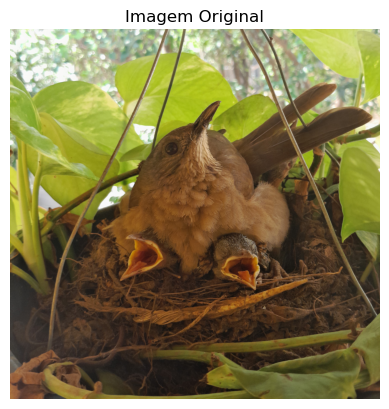

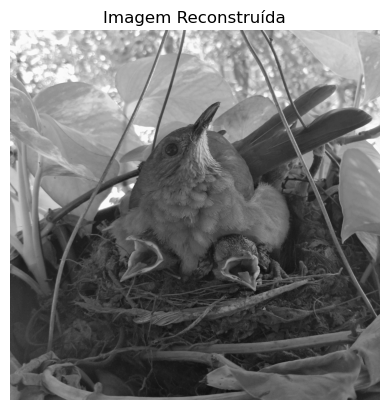

In [9]:
img1 = Image.open(caminho_imagem) # carrega a imagem original
img2 = Image.open(caminho_saida_descomprimida) # carrega a imagem reconstruída

img1_array = np.array(img1) # converte a imagem original para um array numpy
img2_array = np.array(img2) # converte a imagem reconstruída para um array numpy

# exibe a imagem original
plt.title('Imagem Original')
plt.imshow(img1_array)
plt.axis('off')
plt.show()

# exibe a imagem reconstruída
plt.title('Imagem Reconstruída')
plt.imshow(img2_array, cmap = 'gray')
plt.axis('off')
plt.show()